# TCRseq BoxPlots

Script related to figure 7a

### Aim:
- Compare TCR seq clonality and T cell counts in matched and un matched pre/post samples

In [1]:
!python --version

Python 3.6.8 :: Anaconda custom (64-bit)


## Import packages

In [2]:
import scipy.stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [3]:
home = '~/git_repos/HGSOC_TME_Heterogeneity/'

## Get sample labels and TCRseq data

### Load samples' metadata

In [5]:
file_keys = home + 'Data/7/Metadata_TCRseq_Greenbaum.Callahan_2.6.17.tsv'

sample_labels = pd.read_csv(file_keys,
                            sep='\t',
                            skiprows=1)

sample_labels.head()

,Subject ID,Sample ID,Progression Free Survival (Days),"PFS Censored Status (0 = PF, 1=Progressed)",Overall Survival (Days),"OS Censored Status (0 = Alive, 1=Dead)",Type of Chemo,Number of Cycles,Platinum Sensitive,Age,C1D1,Date Last F/u,Status,Date of recurrence,Stage,Site Matched,Comments
0,3368,3368A,771,0,1995,0,Carbo/taxol,6,Y,54,09/11/10,26/04/16,AWD,19/12/12,IIIC,Y,NaN
1,3368,3368B,771,0,1995,0,Carbo/taxol,6,Y,55,09/11/10,26/04/16,AWD,19/12/12,IIIC,Y,NaN
2,7362,7362A,351,1,449,1,Carbo/taxol,6,N,76,04/10/10,27/12/11,DOD,20/09/11,IIIC,Y,NaN
3,7362,7362B,351,1,449,1,Carbo/taxol,6,N,77,04/10/10,27/12/11,DOD,20/09/11,IIIC,Y,NaN
4,371,0371A,900,1,1682,0,Carbo/taxol,3,Y,68,01/08/11,09/03/16,AWD,17/01/14,IV,Y,NaN


###  Load TCRseq data

In [7]:
file_tcr = home + 'Data/7/SampleOverview_04-08-2019_8-43-51_AM.tsv'

tcr_seq = pd.read_csv(file_tcr, sep='\t')

tcr_seq.set_index('sample_name', inplace=True)

tcr_seq.head()

,sample_cells,total_t_cells,fraction_productive_of_cells,productive_rearrangements,productive_clonality,max_productive_frequency,sample_clonality
sample_name,,,,,,,
6229A,145614,2402.0,0.016496,1044,0.2386,0.133169949,0.2178
3935B2,49578,3795.0,0.076538,2529,0.1499,0.0600402541,0.1401
3397B,19843,1679.0,0.084607,1040,0.1046,0.0341284275,0.1045
3418B,93494,3472.0,0.037137,1412,0.1188,0.0267541278,0.1125
4425A,4758,312.0,0.065537,219,0.0819,0.0548156947,0.0753


In [8]:
tcr_seq.columns.values

array(['sample_cells', 'total_t_cells', 'fraction_productive_of_cells',
       'productive_rearrangements', 'productive_clonality',
       'max_productive_frequency', 'sample_clonality'], dtype=object)

In [9]:
tcr_seq["fraction_t_cells_of_nucleated_cells"] = tcr_seq["total_t_cells"]/tcr_seq["sample_cells"]


## Split data into pre (A) and post (B) NACT

### Exclude samples from analysis (based on adaptive biotech recommendation)

In [10]:
exc_patients = {'0511', # due low T cell count (clonality unreliable)
                '2050', # due low T cell count (clonality unreliable)
                '2058', # due low nucleated and T cell count (seq unreliable)
                '2359', # due lack of pre-treatment sample
                '2945', # due low nucleated cell count
                '3582', # due low nucleated and T cell count (seq unreliable)
                '4997', # due low nucleated and T cell count (seq unreliable)
                '5219', # due low T cell count (clonality unreliable)
                '5660', # due low nucleated cell count
                '6902', # due low nucleated and T cell count (seq unreliable)
                '7678'} # due low nucleated and T cell count (seq unreliable)

In [11]:
def restart_dict(mdata):
    
    data_dict = {'matched_site': {}, 'non_matched_site': {}}
    
    for i, patient in enumerate(mdata['Subject ID']):

        if str(patient) not in exc_patients:

            if mdata['Site Matched'][i] == 'Y':
                
                data_dict['matched_site'][str(patient)] = {}
                
            elif mdata['Site Matched'][i] == 'N':
                
                data_dict['non_matched_site'][str(patient)] = {}
                
            else:
                
                raise ValueError()
                
    return data_dict

In [12]:
def assign_score_to_patient(samples_data, score, data_dict):
    
    for i, sample in enumerate(samples_data['Sample ID']):

        patient = str(samples_data['Subject ID'][i])

        if patient not in exc_patients:

            for match in data_dict:
                if patient in data_dict[match]:
                    if sample not in data_dict[match][patient]:
                        data_dict[match][patient][sample] = tcr_seq[score][sample]
                    else:
                        raise ValueError('sample already in patient')

    return data_dict

In [13]:
def matched_unmatched(data_dict):
    
    # matched
    matched_pre = []
    matched_post = []

    # unmatched
    unmatched_pre = []
    unmatched_post = []

    for site in ['matched_site','non_matched_site']:
        for patient in data_dict[site]:

            if patient != '3935':

                for sample in data_dict[site][patient]:

                    if 'A' in sample:
                        if site == 'matched_site':
                            matched_pre.append(float(data_dict[site][patient][sample]))
                        elif site == 'non_matched_site':
                            unmatched_pre.append(float(data_dict[site][patient][sample]))
                    if 'B' in sample:
                        if site == 'matched_site':
                            matched_post.append(float(data_dict[site][patient][sample]))
                        elif site == 'non_matched_site':
                            unmatched_post.append(float(data_dict[site][patient][sample]))
                            
    return matched_pre, matched_post, unmatched_pre, unmatched_post

In [14]:
def matched_df(a, b):
    
    a_b = []
    a_b_labels = []
    for i in range(len(a)):

        ai = a[i]
        bi = b[i]

        a_b.append(ai)
        a_b.append(bi)

        a_b_labels.append('pre')
        a_b_labels.append('post')
    
    data_toplot_matched = pd.DataFrame({'pre_post':pd.Series(a_b),
                                        'pre_post_labels':pd.Series(a_b_labels)})
    
    return data_toplot_matched

In [15]:
def unmatched_df(c, d):
    
    c_d = []
    c_d_labels = []
    for i in range(len(c)):

        ci = c[i]
        di = d[i]

        c_d.append(ci)
        c_d.append(di)

        c_d_labels.append('pre')
        c_d_labels.append('post')
    
    data_toplot_unmatched = pd.DataFrame({'pre_post':pd.Series(c_d),
                                          'pre_post_labels':pd.Series(c_d_labels)})
    
    return data_toplot_unmatched

In [16]:
def boxplot(data_toplot, ylim):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(3,3)

    sns.violinplot(x="pre_post_labels",
                   y="pre_post",
                   data=data_toplot,
                   inner=None,
                   hue="pre_post_labels",
                   split=True,
                   scale="count",
                   scale_hue=False,
                   zorder=0)

    sns.boxplot(x='pre_post_labels',
                y="pre_post",
                data=data_toplot,
                notch=True,
                fliersize=0,
                width=0.5,
                hue="pre_post_labels",
                zorder=1)

    for i,s in enumerate(data_toplot.index):

        y = data_toplot['pre_post'][i]

        if i%2 == 0:
            x = -0.125
            line = [(x,y)]

        else:
            x = 1.125
            line.append((x,y))
            (xs, ys) = zip(*line)

            ax.add_line(Line2D(xs, ys, ls='-', linewidth=1, color='k',alpha=1,zorder=2))
    
    if ylim != None:
        plt.ylim(ylim)
        
    #sns.despine(trim=True,offset=10)
    ax.get_legend().remove()
    
    return fig

### Statistical analysis

In [17]:
def compare_related_samples(a,b):

    normally_distr = None
    equal_variance = None

    #### Normality assumptions
    normaltest_a = scipy.stats.mstats.normaltest(a)[1]
    normaltest_b = scipy.stats.mstats.normaltest(b)[1]

    shapiro_a = scipy.stats.shapiro(a)[1]
    shapiro_b = scipy.stats.shapiro(b)[1]

    normality = sorted([normaltest_a,normaltest_b,shapiro_a,shapiro_b])[0]

    if normality <= 0.05:

        normally_distr = False

    else:

        normally_distr = True

    #### Equal variance
    if normally_distr == True:
        
        print("BARTLETT")

        variance = scipy.stats.bartlett(a,b)[1]

        if variance <= 0.05:

            equal_variance = False

        else:

            equal_variance = True
            
    else:
        print("LEVENE")
        variance = scipy.stats.levene(a,b)[1]

        if variance <= 0.05:

            equal_variance = False

        else:

            equal_variance = True

    #### Comparison test
    if normally_distr == True and equal_variance == True:

        print("PAIRED T-TEST")
        p_val = scipy.stats.ttest_rel(a,b)[1]

    else:

        print("WILCOXON")
        p_val = scipy.stats.wilcoxon(a,b)[1]
        
    return "normal data:",normally_distr,"equal_variance:",equal_variance,"significance:",p_val,"n=",len(a)+len(b)

In [18]:
def compare_batches(a , b):
    
    normally_distr = None
    equal_variance = None

    #### Normality assumptions
    normaltest_a = scipy.stats.mstats.normaltest(a)[1]
    normaltest_b = scipy.stats.mstats.normaltest(b)[1]

    shapiro_a = scipy.stats.shapiro(a)[1]
    shapiro_b = scipy.stats.shapiro(b)[1]

    normality = sorted([normaltest_a,normaltest_b,shapiro_a,shapiro_b])[0]

    if normality <= 0.05:

        normally_distr = False

    else:

        normally_distr = True

    #### Equal variance
    if normally_distr == True:
        
        print("BARTLETT")
        variance = scipy.stats.bartlett(a,b)[1]

        if variance <= 0.05:

            equal_variance = False

        else:

            equal_variance = True
            
    else:
        print("LEVENE")
        variance = scipy.stats.levene(a,b)[1]

        if variance <= 0.05:

            equal_variance = False

        else:

            equal_variance = True

    #### Comparison test
    if normally_distr == True:
        
        if equal_variance == True:
            
            print("PAIRED T-TEST")
            p_val = scipy.stats.ttest_ind(a, b, equal_var=True)[1]
            
        else:
            
            print("WILCOXON")
            p_val = scipy.stats.ttest_ind(a, b, equal_var=False)[1]

    else:
        print("MANN-WHITNEY")
        p_val = scipy.stats.mannwhitneyu(a,b,alternative="two-sided")[1]
        
    return "normal data:",normally_distr,"equal_variance:",equal_variance,"significance:",p_val

## Fraction T Cells of Nucleated Cells

<b>
Fraction T Cells of Nucleated Cells </b>
<p>
The fraction of T cells within the total nucleated cell count (T cells and non-T cells). This value is calculated by dividing the number of Productive Templates by Nucleated Cells (a measure based on the amplification of reference gene primers rather than DNA absorbance).</p>

<b>
Nucleated Cells </b>
<p>
The total number of nucleated cells (includes immune and other cells). This value is based on the amplification of reference gene primers in the assay.

</p>

In [19]:
data_dict = restart_dict(sample_labels)

In [20]:
score = "fraction_t_cells_of_nucleated_cells"

In [21]:
data_dict = assign_score_to_patient(sample_labels, score, data_dict)

In [22]:
matched_pre, matched_post, unmatched_pre, unmatched_post = matched_unmatched(data_dict)

In [23]:
matched_TcellFraction = matched_df(matched_pre, matched_post)

In [24]:
unmatched_TcellFraction = unmatched_df(unmatched_pre, unmatched_post)

In [25]:
matched_TcellFraction

,pre_post,pre_post_labels
0,0.009942,pre
1,0.057733,post
2,0.148697,pre
3,0.223224,post
4,0.580096,pre
5,0.259682,post
6,0.008012,pre
7,0.046783,post
8,0.077409,pre
9,0.133679,post


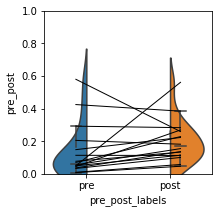

In [26]:
fig = boxplot(matched_TcellFraction, ylim=[-0,1])

In [27]:
compare_related_samples(matched_pre, matched_post)

LEVENE
WILCOXON


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  np.min(n))


('normal data:',
 False,
 'equal_variance:',
 True,
 'significance:',
 0.029873144019229032,
 'n=',
 32)

In [29]:
fig.savefig('../../Figures/main/7/panels/7a_NACT_paired_matched_TcellFraction_comparison.pdf')

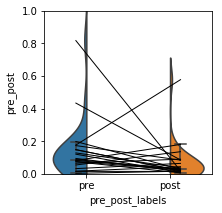

In [30]:
fig = boxplot(unmatched_TcellFraction, ylim=[0,1])

In [31]:
compare_related_samples(unmatched_pre, unmatched_post)

LEVENE
WILCOXON


('normal data:',
 False,
 'equal_variance:',
 True,
 'significance:',
 0.04955245211417102,
 'n=',
 42)

In [32]:
fig.savefig('../../Figures/main/7/panels/7a_NACT_paired_unmatched_TcellFraction_comparison.pdf')

### Compare batches

In [33]:
compare_batches(matched_pre, unmatched_pre)

LEVENE
MANN-WHITNEY


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  np.min(n))


('normal data:',
 False,
 'equal_variance:',
 True,
 'significance:',
 0.4903314427479487)

In [34]:
compare_batches(matched_post, unmatched_post)

LEVENE
MANN-WHITNEY


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  np.min(n))


('normal data:',
 False,
 'equal_variance:',
 True,
 'significance:',
 7.184934096641021e-05)

In [35]:
def boxplot2(data_toplot, score, ylim=None):
    
    fig, ax = plt.subplots()
    fig.set_size_inches(3,3)

    sns.violinplot(x="Matched",
                   y=score,
                   data=data_toplot,
                   inner=None,
                   hue="Matched",
                   split=False,
                   scale="count",
                   scale_hue=False,
                   zorder=0)

    sns.boxplot(x='Matched',
                y=score,
                data=data_toplot,
                notch=True,
                fliersize=0,
                width=0.5,
                hue="Matched",
                zorder=1,
                whis=0)

    
    
    if ylim != None:
        plt.ylim(ylim)
        
    #sns.despine(trim=True,offset=10)
    ax.get_legend().remove()
    
    return fig

In [36]:
matched_df2 = matched_TcellFraction[matched_TcellFraction["pre_post_labels"] == "post"]
matched_df2["Matched"] = "Matched"
matched_df2.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,pre_post,pre_post_labels,Matched
1,0.057733,post,Matched
3,0.223224,post,Matched
5,0.259682,post,Matched
7,0.046783,post,Matched
9,0.133679,post,Matched


In [37]:
unmatched_df2 = unmatched_TcellFraction[unmatched_TcellFraction["pre_post_labels"] == "post"]
unmatched_df2["Matched"] = "Unmatched"
unmatched_df2.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,pre_post,pre_post_labels,Matched
1,0.029426,post,Unmatched
3,0.029159,post,Unmatched
5,0.016002,post,Unmatched
7,0.044182,post,Unmatched
9,0.016517,post,Unmatched


In [38]:
df = matched_df2.append(unmatched_df2)

df.rename(columns={"pre_post": "Fraction_of_Tcells"}, inplace=True)

df.head()

,Fraction_of_Tcells,pre_post_labels,Matched
1,0.057733,post,Matched
3,0.223224,post,Matched
5,0.259682,post,Matched
7,0.046783,post,Matched
9,0.133679,post,Matched


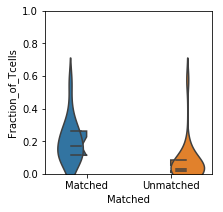

In [39]:
fig = boxplot2(df, "Fraction_of_Tcells", ylim=[0,1])

In [40]:
fig.savefig("../../Figures/supplementary/7/panels/s7c_postNACT_TcellFraction.pdf")

In [41]:
len(df[df.Matched == "Unmatched"])

21

## Productive clonality

<p>
Clonality measure for the sample calculated over all Productive Rearrangements. </p>

<p>
Values for clonality range from 0 to 1. Values near 1 represent samples with one or a few predominant rearrangements (monoclonal or oligoclonal samples) dominating the observed repertoire. Clonality values near 0 represent more polyclonal samples.</p>

<p>
Productive Clonality is calculated by normalizing Productive Entropy using the total number of unique Productive Rearrangements and subtracting the result from 1.</p>


In [42]:
data_dict = restart_dict(sample_labels)

In [43]:
score = "productive_clonality"

In [44]:
data_dict = assign_score_to_patient(sample_labels, score, data_dict)

In [45]:
matched_pre, matched_post, unmatched_pre, unmatched_post = matched_unmatched(data_dict)

In [46]:
matched_TcellProdClonality = matched_df(matched_pre, matched_post)

In [47]:
unmatched_TcellProdClonality = unmatched_df(unmatched_pre, unmatched_post)

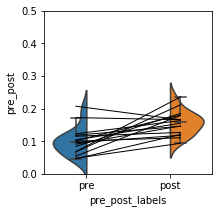

In [48]:
fig = boxplot(matched_TcellProdClonality, ylim=[0,0.5])

In [49]:
compare_related_samples(matched_pre, matched_post)

BARTLETT
PAIRED T-TEST


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  np.min(n))


('normal data:',
 True,
 'equal_variance:',
 True,
 'significance:',
 0.0010924190209392406,
 'n=',
 32)

In [50]:
fig.savefig('../../Figures/main/7/panels/7a_NACT_paired_matched_TcellProdClonality_comparison.pdf')

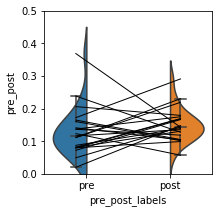

In [51]:
fig = boxplot(unmatched_TcellProdClonality, ylim=[0,0.5])

In [52]:
compare_related_samples(unmatched_pre, unmatched_post)

LEVENE
WILCOXON


('normal data:',
 False,
 'equal_variance:',
 True,
 'significance:',
 0.19243418492041608,
 'n=',
 42)

In [53]:
fig.savefig('../../Figures/main/7/panels/7a_NACT_paired_unmatched_TcellProdClonality_comparison.pdf')

### Compare batches

In [54]:
compare_batches(matched_pre, unmatched_pre)

LEVENE
MANN-WHITNEY


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  np.min(n))


('normal data:',
 False,
 'equal_variance:',
 True,
 'significance:',
 0.17734130123863223)

In [55]:
compare_batches(matched_post, unmatched_post)

LEVENE
MANN-WHITNEY


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  np.min(n))


('normal data:',
 False,
 'equal_variance:',
 True,
 'significance:',
 0.5098156379703556)

In [56]:
matched_df2 = matched_TcellProdClonality[matched_TcellProdClonality["pre_post_labels"] == "post"]
matched_df2["Matched"] = "Matched"
matched_df2.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,pre_post,pre_post_labels,Matched
1,0.1804,post,Matched
3,0.2360,post,Matched
5,0.1182,post,Matched
7,0.1470,post,Matched
9,0.1662,post,Matched


In [57]:
unmatched_df2 = unmatched_TcellProdClonality[unmatched_TcellProdClonality["pre_post_labels"] == "post"]
unmatched_df2["Matched"] = "Unmatched"
unmatched_df2.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,pre_post,pre_post_labels,Matched
1,0.1752,post,Unmatched
3,0.1794,post,Unmatched
5,0.1431,post,Unmatched
7,0.1276,post,Unmatched
9,0.1052,post,Unmatched


In [58]:
df = matched_df2.append(unmatched_df2)

df.rename(columns={"pre_post": "TcellProdClon"}, inplace=True)

df.head()

,TcellProdClon,pre_post_labels,Matched
1,0.1804,post,Matched
3,0.2360,post,Matched
5,0.1182,post,Matched
7,0.1470,post,Matched
9,0.1662,post,Matched


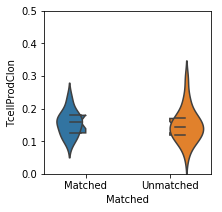

In [59]:
fig = boxplot2(df, "TcellProdClon", ylim=[0,0.5])

In [60]:
fig.savefig("../../Figures/supplementary/7/panels/s7c_postNACT_TcellProdClon.pdf")

In [61]:
len(df[df.Matched == "Unmatched"])

21

## Max Productive Frequency

<p>
The maximum Productive Frequency value found within a sample.</p>

<b>
Productive Frequency </b>
<p>
The frequency of a specific productive rearrangement among all Productive Rearrangements within a sample. Calculated as the Templates for a specific rearrangement divided by the Sum of Productive Templates for a sample. When the counting method is v1 or v2, reads are used in place of templates to estimate this value.</p>

<b>
Templates </b>
<p>
The total number of templates for a specific rearrangement in the sample.</p>

<p>
Template data is not available for samples with Counting Method equal to v1.</p>

<b>
Total Productive Templates (Sum) </b>
<p>
The sum of template counts for all productive rearrangements in the sample. Expect this value to be different than Total T or B cells, due to rounding of template counts for individual rearrangements. This value is not available for samples with Counting Method equal to v1. When using the v2 Counting Method, contact our Technical Support team for more details.</p>

In [62]:
data_dict = restart_dict(sample_labels)

In [63]:
score = "max_productive_frequency"

In [64]:
data_dict = assign_score_to_patient(sample_labels, score, data_dict)

In [65]:
matched_pre, matched_post, unmatched_pre, unmatched_post = matched_unmatched(data_dict)

In [66]:
matched_MaxProdFreq = matched_df(matched_pre, matched_post)

In [67]:
unmatched_MaxProdFreq = unmatched_df(unmatched_pre, unmatched_post)

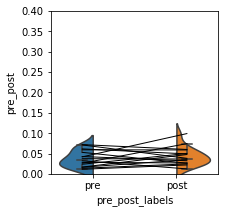

In [68]:
fig = boxplot(matched_MaxProdFreq, ylim=[0,0.4])

In [69]:
compare_related_samples(matched_pre, matched_post)

BARTLETT
PAIRED T-TEST


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  np.min(n))
/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  np.min(n))


('normal data:',
 True,
 'equal_variance:',
 True,
 'significance:',
 0.42011010449144826,
 'n=',
 32)

In [70]:
fig.savefig('../../Figures/main/7/panels/7a_NACT_paired_matched_MaxProdFreq_comparison.pdf')

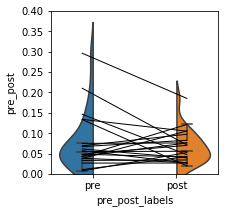

In [71]:
fig = boxplot(unmatched_MaxProdFreq, ylim=[0,0.4])

In [72]:
compare_related_samples(unmatched_pre, unmatched_post)

LEVENE
WILCOXON


('normal data:',
 False,
 'equal_variance:',
 True,
 'significance:',
 0.8483946983538319,
 'n=',
 42)

In [73]:
fig.savefig('../../Figures/main/7/panels/7a_NACT_paired_unmatched_MaxProdFreq_comparison.pdf')

### Compare batches

In [74]:
compare_batches(matched_pre, unmatched_pre)

LEVENE
MANN-WHITNEY


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  np.min(n))


('normal data:',
 False,
 'equal_variance:',
 True,
 'significance:',
 0.035728644278742644)

In [75]:
compare_batches(matched_post, unmatched_post)

LEVENE
MANN-WHITNEY


/anaconda3/lib/python3.6/site-packages/scipy/stats/mstats_basic.py:2469: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  np.min(n))


('normal data:',
 False,
 'equal_variance:',
 True,
 'significance:',
 0.05156862404704739)

In [76]:
len(unmatched_post)

21

In [77]:
matched_df2 = matched_MaxProdFreq[matched_MaxProdFreq["pre_post_labels"] == "post"]
matched_df2["Matched"] = "Matched"
matched_df2.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,pre_post,pre_post_labels,Matched
1,0.049055,post,Matched
3,0.074201,post,Matched
5,0.024536,post,Matched
7,0.038200,post,Matched
9,0.036464,post,Matched


In [78]:
unmatched_df2 = unmatched_MaxProdFreq[unmatched_MaxProdFreq["pre_post_labels"] == "post"]
unmatched_df2["Matched"] = "Unmatched"
unmatched_df2.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,pre_post,pre_post_labels,Matched
1,0.097324,post,Unmatched
3,0.082473,post,Unmatched
5,0.185136,post,Unmatched
7,0.019810,post,Unmatched
9,0.070919,post,Unmatched


In [79]:
df = matched_df2.append(unmatched_df2)

df.rename(columns={"pre_post": "MaxProdFreq"}, inplace=True)

df.head()

,MaxProdFreq,pre_post_labels,Matched
1,0.049055,post,Matched
3,0.074201,post,Matched
5,0.024536,post,Matched
7,0.038200,post,Matched
9,0.036464,post,Matched


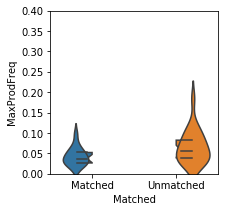

In [80]:
fig = boxplot2(df, "MaxProdFreq", ylim=[0,0.4])

In [81]:
fig.savefig("../../Figures/main/7/panels/s7c_postNACT_MaxProdFreq.pdf")

In [82]:
len(df[df.Matched == "Unmatched"])

21

# End script